In [37]:
from keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import layers
from keras import models
import tensorflow as tf

In [38]:
import os

# Caminho local para a pasta raiz do projeto
root_path = "./"  # ou o caminho absoluto, ex: "C:/Users/teu_usuario/Documents/SSC-AI-GARBAGE-DETECTION"

# Listar diretórios no caminho raiz
print("📁 Diretórios no caminho raiz:")
print(os.listdir(root_path))

# Verificar conteúdo de um caminho específico
specific_path = os.path.join(root_path, "garbage-noaug-70-15-15")
if os.path.exists(specific_path):
    print(f"\n📁 Conteúdo de {specific_path}:")
    print(os.listdir(specific_path))
else:
    print(f"\n❌ Caminho {specific_path} não existe")

# Função para listar diretórios com profundidade
def list_dirs(path, indent=0):
    for item in os.listdir(path):
        full_path = os.path.join(path, item)
        if os.path.isdir(full_path):
            print(" " * indent + "📁 " + item)
            if indent < 4:
                list_dirs(full_path, indent + 2)
        else:
            print(" " * indent + "📄 " + item)

# Explorar estrutura de diretórios
print("\n📂 Estrutura de diretórios:")
list_dirs(root_path, 0)

📁 Diretórios no caminho raiz:
['garbage-dataset-aug-87-6-6', '.DS_Store', 'requirements.txt', 'garbage-dataset', 'model_checkpoint.h5', 'garbage-noaug-70-15-15', 'garbage_classifier.weights.h5', '.gitignore', '.venv', 'ssc.py', '.git', 'SSC.ipynb', 'garbage_classifier_model.keras']

📁 Conteúdo de ./garbage-noaug-70-15-15:
['README.roboflow.txt', 'valid', 'README.dataset.txt', '.DS_Store', 'test', 'train']

📂 Estrutura de diretórios:
📁 garbage-dataset-aug-87-6-6
  📄 README.roboflow.txt
  📁 valid
    📁 paper
    📁 clothes
    📁 metal
    📁 cardboard
    📁 trash
    📁 glass
    📁 biological
    📁 battery
    📁 plastic
    📁 shoes
  📄 README.dataset.txt
  📁 test
    📁 paper
    📁 clothes
    📁 metal
    📁 cardboard
    📁 trash
    📁 glass
    📁 biological
    📁 battery
    📁 plastic
    📁 shoes
  📁 train
    📁 paper
    📁 clothes
    📁 metal
    📁 cardboard
    📁 trash
    📁 glass
    📁 biological
    📁 battery
    📁 plastic
    📁 shoes
📄 .DS_Store
📄 requirements.txt
📁 garbage-dataset
  📁 

In [39]:
# Improved Metal GPU detection for Apple Silicon
try:
    # First try looking for GPU devices (newer TF versions label Metal as GPU)
    gpus = tf.config.list_physical_devices('GPU')
    if len(gpus) > 0:
        print(f"Found {len(gpus)} GPU device(s)")
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("GPU acceleration enabled (Metal)")
    # If no GPU found, try looking specifically for MPS devices
    elif hasattr(tf.config, 'list_physical_devices') and len(tf.config.list_physical_devices('MPS')) > 0:
        mps_devices = tf.config.list_physical_devices('MPS')
        tf.config.experimental.set_visible_devices(mps_devices[0], 'MPS')
        print("MPS (Metal) device enabled")
    else:
        print("No GPU or MPS device found, using CPU")
        
    # Verify what device is being used
    print("\nDevice being used:", tf.config.get_visible_devices())
    
    # Test with a simple operation to confirm GPU usage
    with tf.device('/GPU:0'):
        a = tf.constant([[1.0, 2.0], [3.0, 4.0]])
        b = tf.constant([[5.0, 6.0], [7.0, 8.0]])
        c = tf.matmul(a, b)
        print("Matrix multiplication result:", c)
        print("GPU test successful!")
except Exception as e:
    print(f"Error setting up GPU: {e}")
    print("Falling back to CPU")

Found 1 GPU device(s)
GPU acceleration enabled (Metal)

Device being used: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Matrix multiplication result: tf.Tensor(
[[19. 22.]
 [43. 50.]], shape=(2, 2), dtype=float32)
GPU test successful!


In [49]:
# Enable mixed precision (faster on GPU)
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')  # Use FP16 instead of FP32

In [ ]:
train_dir = specific_path + "/train"
validation_dir = specific_path + "/valid"
test_dir = specific_path + "/test"

# Images are 640, but 224 is way faster for training
IMG_SIZE = 160
BATCH_SIZE = 64


train_dataset = image_dataset_from_directory(
    train_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

validation_dataset = image_dataset_from_directory(
    validation_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)



Found 13833 files belonging to 10 classes.
Found 2965 files belonging to 10 classes.
Found 2964 files belonging to 10 classes.


In [51]:
train_dataset_pref = train_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset_pref = validation_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset_pref = test_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)


In [52]:
# Add this code to check class balance
import pandas as pd

class_counts = {}
for _, labels in train_dataset:
    for label in labels.numpy():
        if label not in class_counts:
            class_counts[label] = 0
        class_counts[label] += 1

df = pd.DataFrame({'class': train_dataset.class_names, 'count': [class_counts.get(i, 0) for i in range(len(train_dataset.class_names))]})
print(df)

        class  count
0     battery    666
1  biological    690
2   cardboard   1297
3     clothes   3730
4       glass   2093
5       metal    708
6       paper   1184
7     plastic   1382
8       shoes   1410
9       trash    673


2025-05-31 16:10:52.948328: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [56]:
# Simpler CNN architecture for faster training
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = layers.Rescaling(1./255)(inputs)

# Reduced number of filters and layers for faster training
x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D()(x)

x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D()(x)

x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D()(x)

# Simplified dense layers
x = layers.Flatten()(x)
x = layers.Dropout(0.3)(x)  # Reduced dropout
x = layers.Dense(256, activation='relu')(x)  # Smaller dense layer
outputs = layers.Dense(len(train_dataset.class_names), activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

# Use a simpler optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Compile with better optimizer
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary to see the reduction in parameters
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_4 (Rescaling)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 160, 160, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 80, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 80, 80, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 40, 40, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │    13,107,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,203,274 (50.37 MB)

 Trainable params: 13,203,274 (50.37 MB)

 Non-trainable params: 0 (0.00 B)

In [57]:
# Add to your training cell
import time

class TimeoutCallback(tf.keras.callbacks.Callback):
    def __init__(self, max_time_mins=2):
        super().__init__()
        self.max_time_sec = max_time_mins * 60
        self.start_time = time.time()
        
    def on_epoch_end(self, epoch, logs=None):
        elapsed = time.time() - self.start_time
        if elapsed > self.max_time_sec:
            print(f"\nReached time limit ({self.max_time_sec/3600:.1f}h). Stopping training.")
            self.model.stop_training = True

# Maximum 20 minutes of training to prevent overheating
timeout_cb = TimeoutCallback(max_time_mins=20)


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    patience=5,
    restore_best_weights=True
)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "models/model_checkpoint.keras", 
    save_best_only=True,
    monitor="val_accuracy"
)

# Add more callbacks for better training
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Calculate class weights
total = sum(class_counts.values())
class_weight = {i: total/count for i, count in class_counts.items()}


In [61]:
# Enhanced resource monitoring callback
import psutil
import subprocess
import platform

class ResourceMonitorCallback(tf.keras.callbacks.Callback):
    def __init__(self, check_interval=1):
        super().__init__()
        self.check_interval = check_interval
        self.epoch_count = 0
        # Check if we're on macOS
        self.is_mac = platform.system() == 'Darwin'
        
    def get_mac_temp(self):
        """Get temperature information on macOS"""
        try:
            # Try using osx-cpu-temp if installed
            result = subprocess.run(['osx-cpu-temp'], capture_output=True, text=True)
            if result.returncode == 0:
                return result.stdout.strip()
            
            # Alternative: use system_profiler
            cmd = ['system_profiler', 'SPHardwareDataType']
            result = subprocess.run(cmd, capture_output=True, text=True)
            if "Temperature" in result.stdout:
                for line in result.stdout.split('\n'):
                    if "Temperature" in line:
                        return line.strip()
            return "Temperature data not available"
        except Exception as e:
            return f"Error getting temperature: {e}"
    
    def get_gpu_info(self):
        """Get GPU usage info"""
        try:
            if self.is_mac:
                # On Mac, check if GPU is being used via Metal
                cmd = ['ps', '-A', '|', 'grep', 'AMDMTLBronzeDriver']
                result = subprocess.run(cmd, shell=True, capture_output=True, text=True)
                if result.stdout:
                    return "GPU is active (Metal)"
                return "GPU status unknown"
            else:
                # For non-Mac systems
                return "GPU monitoring not implemented for this OS"
        except Exception as e:
            return f"Error checking GPU: {e}"
        
    def on_epoch_end(self, epoch, logs=None):
        self.epoch_count += 1
        if self.epoch_count % self.check_interval == 0:
            # CPU info
            cpu_percent = psutil.cpu_percent(interval=1)
            
            # Memory info
            memory_info = psutil.virtual_memory()
            
            # Temperature (macOS)
            temp_info = self.get_mac_temp() if self.is_mac else "N/A"
            
            # GPU info
            gpu_info = self.get_gpu_info()
            
            print(f"\n------ System Status (Epoch {epoch}) ------")
            print(f"CPU: {cpu_percent}%")
            print(f"Memory: {memory_info.percent}% ({memory_info.used / 1024**3:.1f}GB / {memory_info.total / 1024**3:.1f}GB)")
            print(f"Temperature: {temp_info}")
            print(f"GPU Status: {gpu_info}")
            print("---------------------------------------")

# Add to callbacks list
resource_monitor = ResourceMonitorCallback(check_interval=1)  # Check every epoch

In [60]:
# TRAINN!!!!
history = model.fit(
    train_dataset_pref,
    validation_data=validation_dataset_pref,
    epochs=20,
    class_weight=class_weight, 
    callbacks=[early_stopping, reduce_lr, checkpoint_cb, timeout_cb, resource_monitor]
)

Epoch 1/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.2170 - loss: 34.4171


Epoch 0 - CPU: 10.6%, Memory: 83.3%
433/433 ━━━━━━━━━━━━━━━━━━━━ 39s 83ms/step - accuracy: 0.2173 - loss: 34.3903 - val_accuracy: 0.4270 - val_loss: 1.8189 - learning_rate: 0.0010
Epoch 2/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.4762 - loss: 16.5899
Epoch 1 - CPU: 8.6%, Memory: 77.3%
433/433 ━━━━━━━━━━━━━━━━━━━━ 33s 76ms/step - accuracy: 0.4762 - loss: 16.5911 - val_accuracy: 0.3970 - val_loss: 2.3034 - learning_rate: 0.0010
Epoch 3/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.4839 - loss: 20.7223
Epoch 2 - CPU: 11.6%, Memory: 78.1%
433/433 ━━━━━━━━━━━━━━━━━━━━ 33s 77ms/step - accuracy: 0.4839 - loss: 20.7410 - val_accuracy: 0.2820 - val_loss: 7.5843 - learning_rate: 0.0010
Epoch 4/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.4504 - loss: 54.4480


Epoch 3 - CPU: 15.2%, Memory: 80.8%
433/433 ━━━━━━━━━━━━━━━━━━━━ 34s 78ms/step - accuracy: 0.4504 - loss: 54.4538 - val_accuracy: 0.4769 - val_loss: 6.4184 - learning_rate: 0.0010
Epoch 5/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5597 - loss: 52.7203


Epoch 4 - CPU: 18.2%, Memory: 82.3%
433/433 ━━━━━━━━━━━━━━━━━━━━ 34s 79ms/step - accuracy: 0.5598 - loss: 52.7119 - val_accuracy: 0.5575 - val_loss: 5.6848 - learning_rate: 2.0000e-04
Epoch 6/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5987 - loss: 51.8676
Epoch 5 - CPU: 10.3%, Memory: 78.0%
433/433 ━━━━━━━━━━━━━━━━━━━━ 33s 77ms/step - accuracy: 0.5987 - loss: 51.8690 - val_accuracy: 0.5508 - val_loss: 6.2073 - learning_rate: 2.0000e-04
Epoch 7/20
432/433 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5647 - loss: 62.2790


Epoch 6 - CPU: 16.9%, Memory: 82.3%
433/433 ━━━━━━━━━━━━━━━━━━━━ 33s 76ms/step - accuracy: 0.5648 - loss: 62.2657 - val_accuracy: 0.5693 - val_loss: 6.0903 - learning_rate: 2.0000e-04
Epoch 8/20
432/433 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.6262 - loss: 53.1165
Epoch 7 - CPU: 36.1%, Memory: 81.0%
433/433 ━━━━━━━━━━━━━━━━━━━━ 33s 76ms/step - accuracy: 0.6263 - loss: 53.1047 - val_accuracy: 0.5656 - val_loss: 6.2412 - learning_rate: 4.0000e-05
Epoch 9/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.6235 - loss: 51.7779
Epoch 8 - CPU: 14.2%, Memory: 78.9%
433/433 ━━━━━━━━━━━━━━━━━━━━ 34s 79ms/step - accuracy: 0.6235 - loss: 51.7729 - val_accuracy: 0.5639 - val_loss: 6.3675 - learning_rate: 4.0000e-05
Epoch 10/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.6232 - loss: 52.0211
Epoch 9 - CPU: 17.0%, Memory: 79.6%
433/433 ━━━━━━━━━━━━━━━━━━━━ 34s 79ms/step - accuracy: 0.6232 - loss: 52.0160 - val_accuracy: 0.5605 - val_loss: 6.4312 - learning_rate: 4.0000e-0


Epoch 10 - CPU: 10.1%, Memory: 73.5%
433/433 ━━━━━━━━━━━━━━━━━━━━ 34s 79ms/step - accuracy: 0.6204 - loss: 51.6007 - val_accuracy: 0.5801 - val_loss: 6.1696 - learning_rate: 8.0000e-06
Epoch 12/20
432/433 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.6356 - loss: 50.7961


Epoch 11 - CPU: 15.2%, Memory: 69.6%
433/433 ━━━━━━━━━━━━━━━━━━━━ 33s 76ms/step - accuracy: 0.6356 - loss: 50.7849 - val_accuracy: 0.5852 - val_loss: 6.0736 - learning_rate: 8.0000e-06
Epoch 13/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.6350 - loss: 50.7055
Epoch 12 - CPU: 7.6%, Memory: 69.6%
433/433 ━━━━━━━━━━━━━━━━━━━━ 33s 76ms/step - accuracy: 0.6350 - loss: 50.7009 - val_accuracy: 0.5798 - val_loss: 6.1550 - learning_rate: 8.0000e-06
Epoch 14/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.6364 - loss: 50.5651
Epoch 13 - CPU: 7.3%, Memory: 70.6%
433/433 ━━━━━━━━━━━━━━━━━━━━ 33s 76ms/step - accuracy: 0.6364 - loss: 50.5585 - val_accuracy: 0.5841 - val_loss: 6.1033 - learning_rate: 1.6000e-06
Epoch 15/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.6365 - loss: 50.6576
Epoch 14 - CPU: 6.2%, Memory: 68.5%
433/433 ━━━━━━━━━━━━━━━━━━━━ 33s 76ms/step - accuracy: 0.6365 - loss: 50.6518 - val_accuracy: 0.5801 - val_loss: 6.1546 - learning_rate: 1.6000

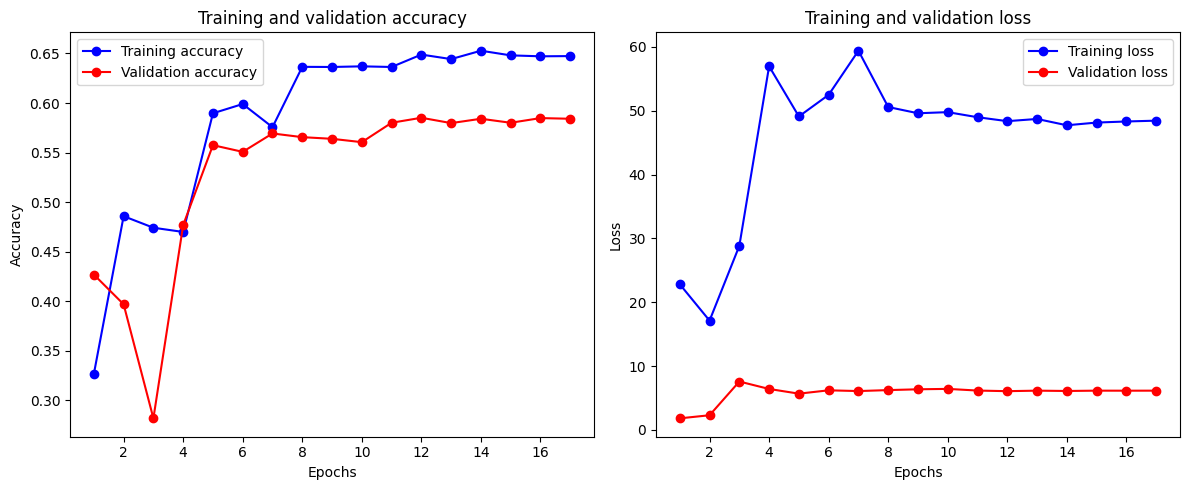

In [62]:
# Corrected plotting code for newer TensorFlow versions
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Save the entire model (architecture + weights + optimizer state)
model.save("models/garbage_classifier_model.keras")  # Add .keras extension

# Or save just the weights if you prefer
model.save_weights("models/garbage_classifier.weights.h5")

print("Model saved successfully!")


2025-05-31 16:26:24.317189: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-05-31 16:26:24.326975: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Model saved successfully!


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.6133 - loss: 5.6072
Test accuracy: 0.5975
Test loss: 5.7777
Classes: ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


2025-05-31 16:27:13.204993: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


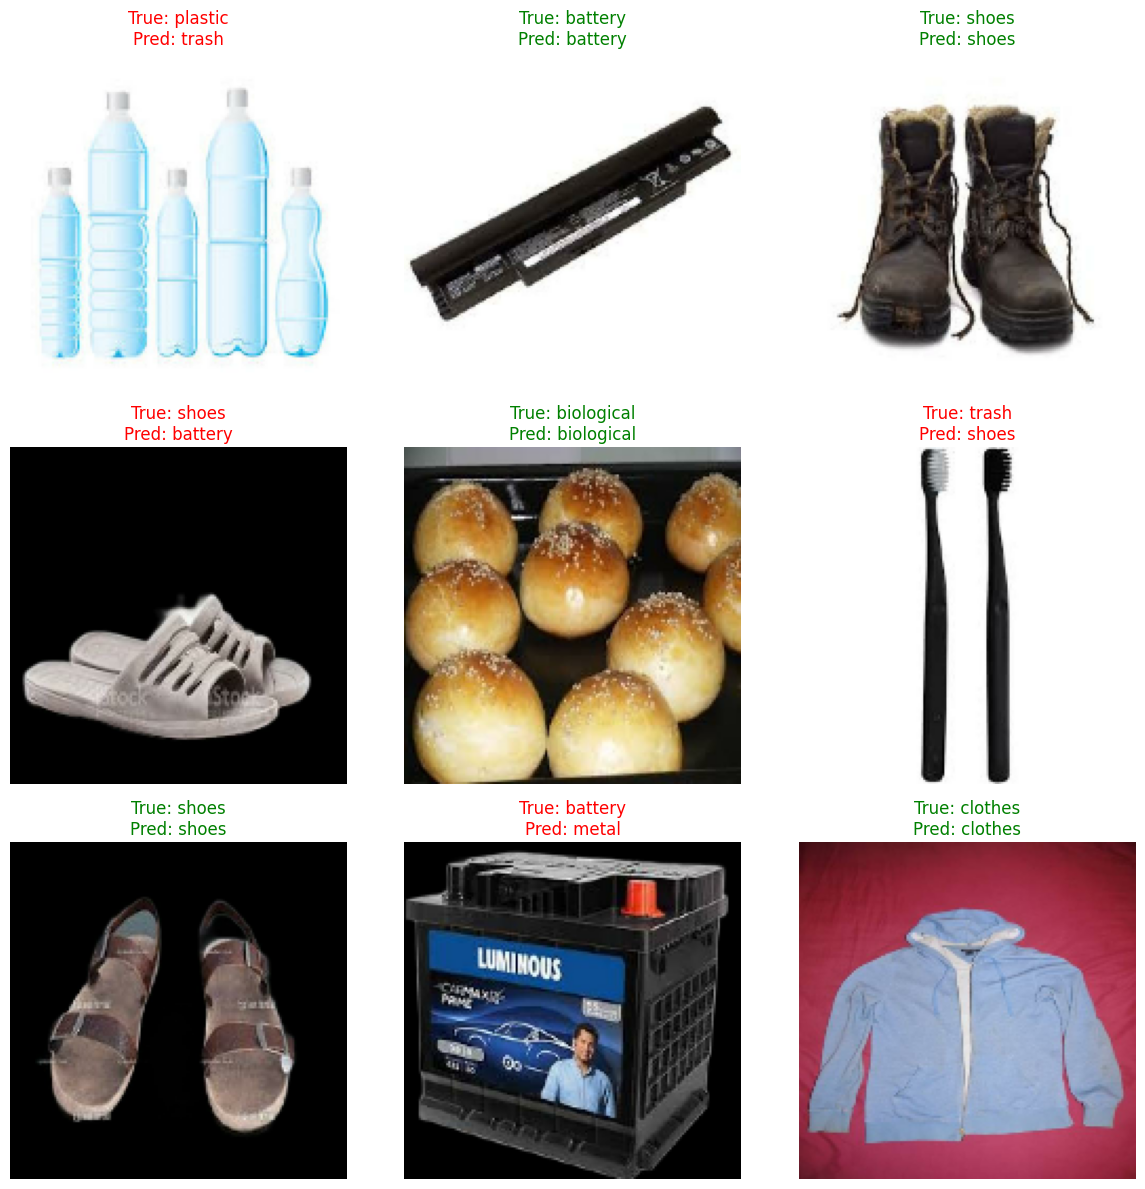

In [66]:
# Evaluate on test dataset
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

# Visualize some predictions
import numpy as np

# Get class names from your dataset
class_names = train_dataset.class_names
print("Classes:", class_names)

# Function to show predictions for a batch of images
plt.figure(figsize=(12, 12))
for images, labels in test_dataset.take(1):
    predictions = model.predict(images)
    pred_classes = np.argmax(predictions, axis=1)
    
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        correct = labels[i] == pred_classes[i]
        color = "green" if correct else "red"
        
        plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[pred_classes[i]]}", 
                 color=color)
        plt.axis("off")
plt.tight_layout()
plt.show()